# **Основы машинного обучения**

<div style="border:solid Blue 2px; padding: 20px">

***Описание проекта:***
    
1. Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

2. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. 

3. Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас. 

4. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся. 

5. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.  

6. А именно: 
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: 
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.


<div style="border:solid Blue 2px; padding: 20px">

***Описание данных:***

**Датасет -** "/datasets/gym_churn.csv"
1. Данные клиента за предыдущий до проверки факта оттока месяц: 
- **'gender'** — пол;
- **'Near_Location'** — проживание или работа в районе, где находится фитнес-центр;
- **'Partner'** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- **'Promo_friends'** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- **'Phone'** — наличие контактного телефона;
- **'Age'** — возраст;
- **'Lifetime'** — время с момента первого обращения в фитнес-центр (в месяцах).
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента: 
- **'Contract_period'** — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- **'Month_to_end_contract'** — срок до окончания текущего действующего абонемента (в месяцах);
- **'Group_visits'** — факт посещения групповых занятий;
- **'Avg_class_frequency_total'** — средняя частота посещений в неделю за все время с начала действия абонемента;
- **'Avg_class_frequency_current_month'** — средняя частота посещений в неделю за предыдущий месяц;
- **'Avg_additional_charges_total'** — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- **'Churn'** — факт оттока в текущем месяце.

## **Предобработка данных**

### Выгрузим библиотеки и ознакомимся с датафреймами

In [1]:
#Загрузим библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import time
import random
import warnings
warnings.filterwarnings("ignore")
import re
import ast
from scipy import stats as st
pd.options.display.max_colwidth = 130

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
#Загрузим датасет
try:
    gym = pd.read_csv('gym_churn.csv')
except:
    gym = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
#Ознакомимся с датасетом
display(gym.head(10))
gym.info()
print('---------------------')
print('Дубликатов в датафрейме -', gym.duplicated().sum())
print('Пропусков в датафрейме -', gym.isna().sum())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
#Работа со столбцами
gym.columns = gym.columns.str.lower()
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

<div style="border:solid Blue 2px; padding: 20px">

***Вывод:***
- **Дубликатов -** 0
- **Пропусков -** 0
- Тип данных в правильном виде
- Столбцы приведены к правильному формату

## **Исследовательский анализ данных**

### Изучим средние значения и стандартные отклонения 

In [5]:
#Посмотрим на информацию и "перевернем" .describe() методом .T
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**

- **gender** - разделение по полу практически идентично;
- **near_location** - клиенты, проживающие или работающие в данном районе, составляют почти 85%;
- **partner** - 49% клиентов - сотрудники компании-партнёра клуба;
- **promo_friends** - 31% клиентов в рамках акции "приведи друга";
- **phone** - у 90% клиентов указан номер телефона;
- **contract_period** - средняя длительности абонементов - 4.7 месяца;
- **group_visits** - 41% клиентов посещают групповые занятия;
- **age** - средний возраст 29 лет;
- **avg_additional_charges_total** - средняя дополнительная выручка - 147 у.е.;
- **month_to_end_contract** - средний срок до окончания абонемента 4.3 месяца;
- **lifetime** - в среднем 3.7 месяца проходит с момента первого обращения в фитнес-центр;
- **avg_class_frequency_total** - средняя частота посещений в неделю за все время с начала действия абонемента - 1.9;
- **avg_class_frequency_current_month** - средняя частота посещений в неделю за предыдущий месяц - 1.8;
- **churn** - факт оттока - 26%.

### Посмотрим на средние значения признаков в двух группах

In [6]:
gym.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**

- **gender** - разница незначительная;
- **near_location** - разница в 10%;
- **partner** - разница в 17%;
- **promo_friends** - разница в 17%
- **phone** - разница незначительная;
- **contract_period** - разница в 4.1 месяца;
- **group_visits** - разница в 19%;
- **age** - разница в 3 года;
- **avg_additional_charges_total** - разница в 43 у.е.;
- **month_to_end_contract** - разница в 3.6%;
- **lifetime** - разница огромная, почти 3.8;
- **avg_class_frequency_total** - разница почти в половину недели;
- **avg_class_frequency_current_month** - разница в 1 месяц;

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [7]:
#Разделим столбец на тех, кто ушел и тех, кто остался
churn_1 = gym[gym['churn'] == 1]
churn_0 = gym[gym['churn'] == 0]

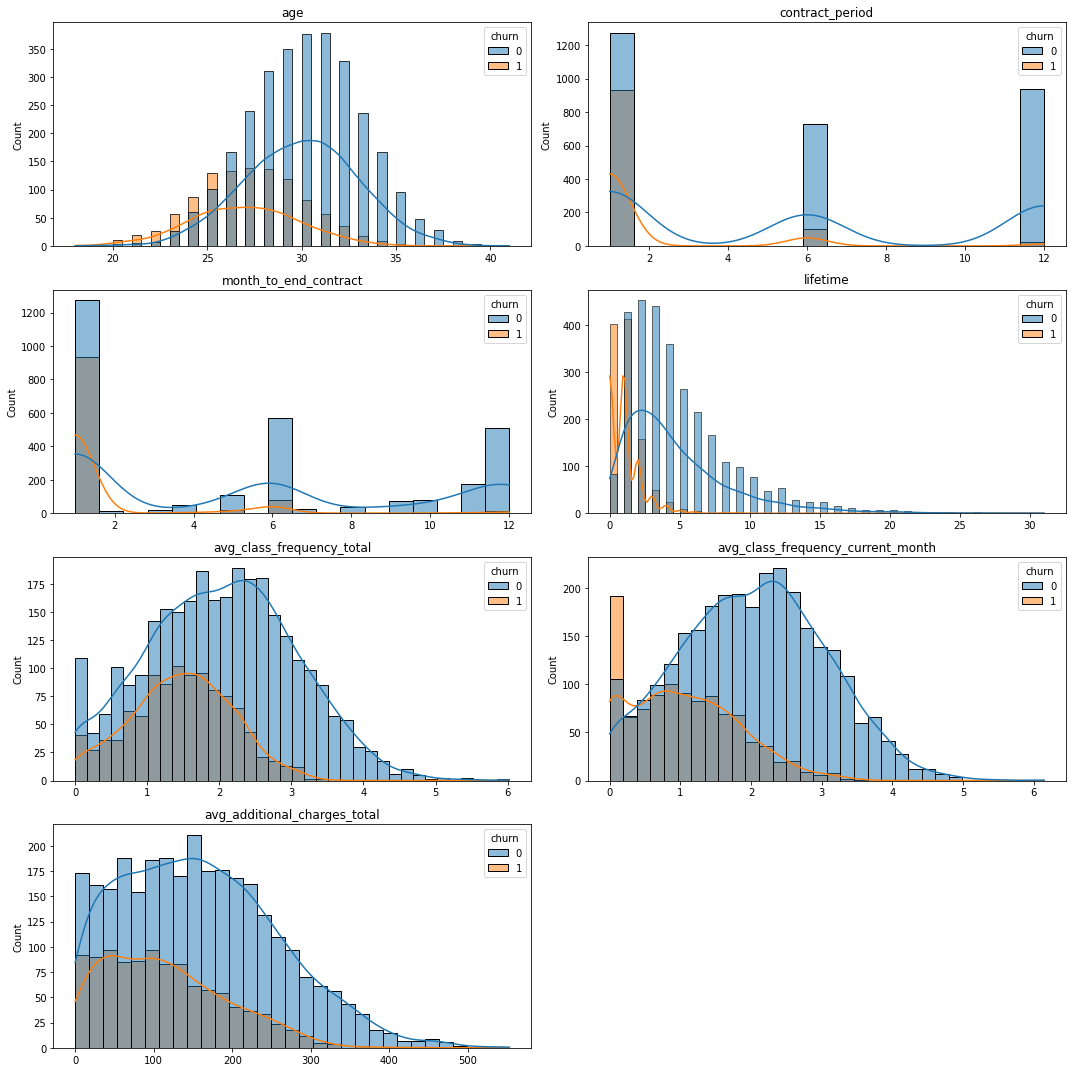

In [8]:
#Строим гистограмы
num_features = ['age', 'contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 
'avg_additional_charges_total']


number_row = int(len(num_features)/2)

fig, ax = plt.subplots(nrows = number_row + 1, ncols=2, figsize=(15, 15))
ax = ax.flatten()

for i in range(len(num_features)):
    
    sns.histplot(data = gym, x = gym[num_features[i]], hue='churn', ax=ax[i], kde = True)
    ax[i].set_title(f'{num_features[i]}')
    ax[i].set_xlabel('')

fig.delaxes(ax[-1])  
fig.tight_layout()
fig.show()

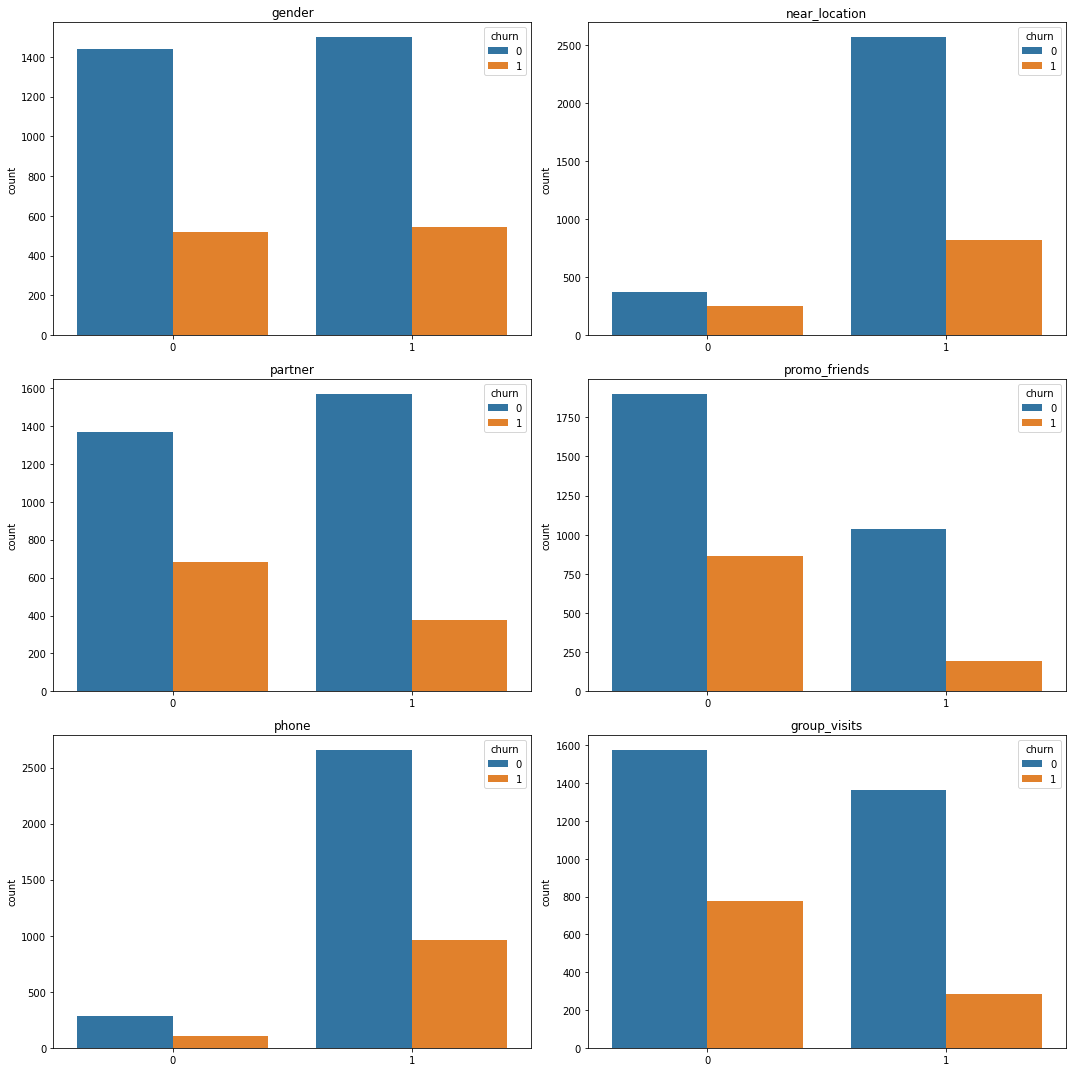

In [9]:
num_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

number_row = int(len(num_features)/2)

fig, ax = plt.subplots(nrows = number_row, ncols=2, figsize=(15, 15))
ax = ax.flatten()

for i in range(len(num_features)):
    
    sns.countplot(data = gym, x=gym[num_features[i]], hue='churn', ax=ax[i]) 
    ax[i].set_title(f'{num_features[i]}')
    ax[i].set_xlabel('')

fig.tight_layout()
fig.show()

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
- По всем графикам видно, что число ушедших(отток)клиентов меньше, чем тех, кто остался

### Построим матрицу корреляций и отобразим ее

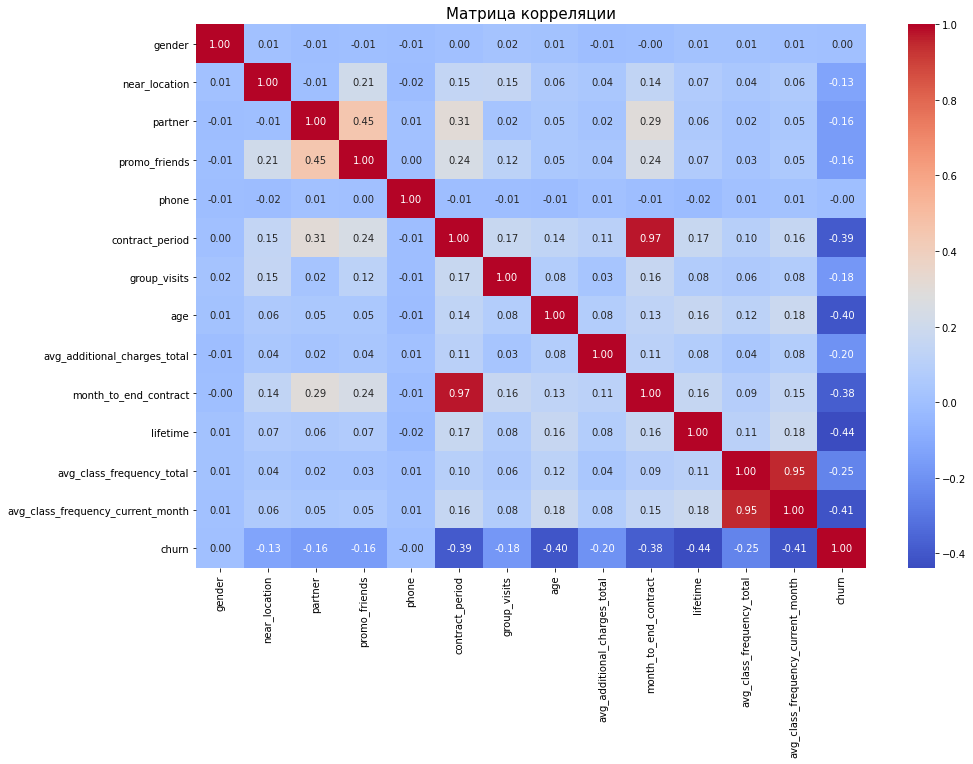

In [10]:
corr_matrix = gym.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix , annot = True, fmt = '0.2f', cmap='coolwarm')
plt.title('Матрица корреляции', fontsize=15)
plt.show()

In [11]:
#Уберем мультиколлиниарность
gym_m = gym.drop(['month_to_end_contract','avg_class_frequency_total'], axis=1)

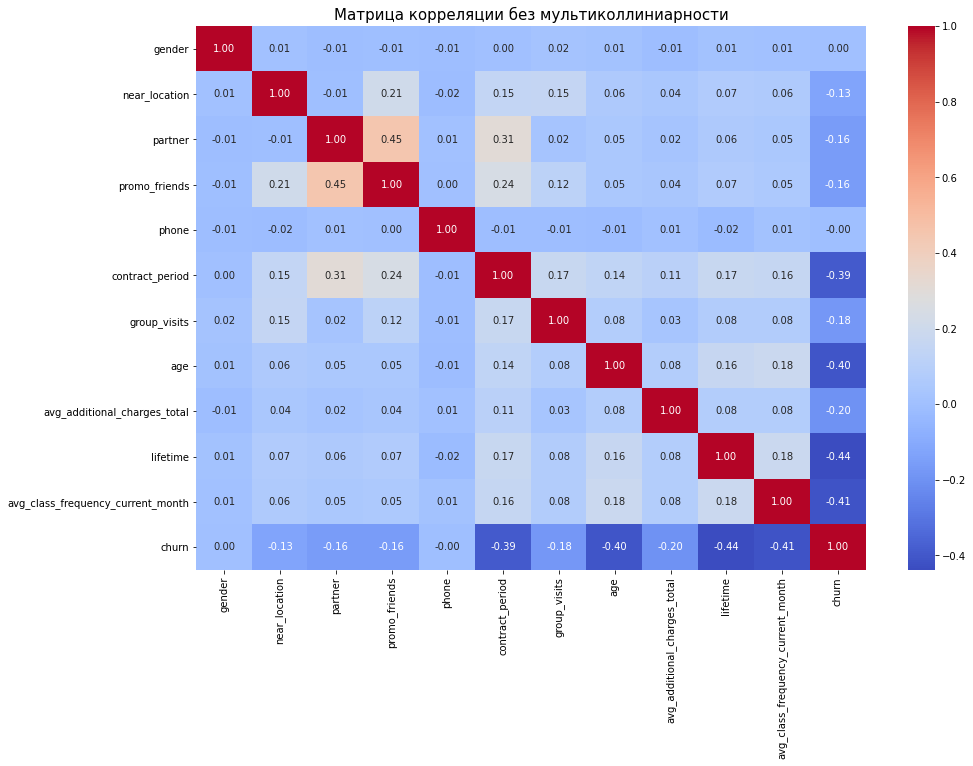

In [12]:
corr_matrix = gym_m.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix , annot = True, fmt = '0.2f', cmap='coolwarm')
plt.title('Матрица корреляции без мультиколлиниарности', fontsize=15)
plt.show()

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
- Заметна корреляция между 'avg_class_frequency_total' и 'avg_class_frequency_current_month', 'contract_period' и 'month_to_end_contract'.
- Убрали сильновлияющую мультиколлиниарность.
- По матрице сразу можно заметить, что пол(gender) и наличие контактного телефона(phone) никак не влияют на отток клиентов;
- Длительность текущего действующего абонемента(Contract_period), возраст(age), длительность абонемента(Month_to_end_contract, Avg_class_frequency_current_month), время с момента первого обращения сильно влияют на отток клиентов(lifetime);
- Также можно выделить признаки, которые дают не особо сильную корреляцию, это такие, как: проживание или работа в районе, где находится фитнес-центр(near-location), сотрудник компании-партнёра клуба(partner), "приведи друга"(promo_friends), групповые занятия(group_bisits) и выручка с дополнительных услуг(Avg_additional_charges_total)

## **Построим модель прогнозирования оттока клиентов**

### Разобьем данные на обучающую и валидационную выборку функцией train_test_split()

In [13]:
#Разделим  данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop('churn', axis = 1)
y = gym['churn']

In [14]:
#Разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучим модель на train-выборке

#### Логистическая регрессия

In [15]:
logistic_model = LogisticRegression(random_state=0)

logistic_model.fit(X_train_st, y_train)

logistic_predictions = logistic_model.predict(X_test_st)


print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logistic_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, logistic_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logistic_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, logistic_predictions)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84


#### Случайный лес

In [16]:
r_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

r_forest_model.fit(X_train_st, y_train)

r_forest_predictions = r_forest_model.predict(X_test_st)


print('Accuracy: {:.2f}'.format(accuracy_score(y_test, r_forest_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, r_forest_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, r_forest_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, r_forest_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83


<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
- Логистическая регрессия и случайный лес практически идентичны, однако логистическая регрессия показала себя немного лучше

## **Кластеризация клиентов**

### Стандартизируем данные

In [17]:
#Создадим новый датафрейм без "churn"
df = gym.drop(['churn'], axis = 1)
df_columns = df.columns

In [18]:
#Стандартизация данных
sc = StandardScaler()
X_sc = sc.fit_transform(df)

### Построим матрицу расстояний 

In [19]:
#Строим матрицу
linked = linkage(X_sc, method = 'ward')

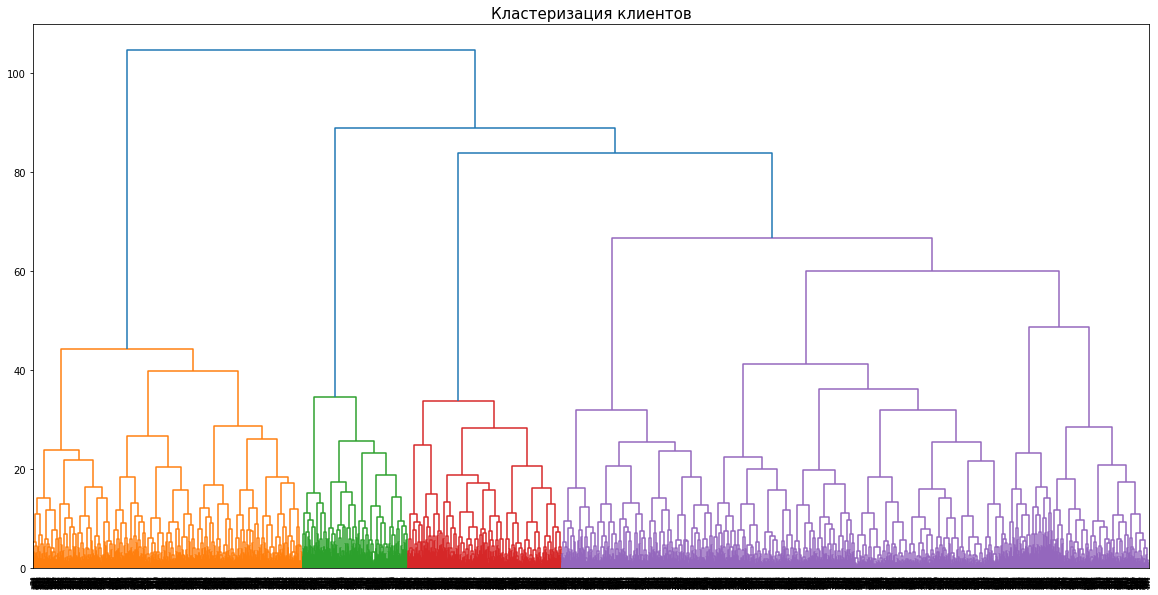

In [20]:
#Строим дендограмму
plt.figure(figsize=(20, 10))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация клиентов', fontsize=15)
plt.show()

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
- Выделяется 6 основных кластеров

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [21]:
#Обучим модель, взяв n=5
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(df)
gym['cluster'] = labels

### Посмотритм на средние значения признаков для кластеров

In [22]:
(
    gym.groupby('cluster')
    .mean()
    .T
    .style
    .background_gradient(cmap='coolwarm', axis=1)
    .set_precision(2)
)

cluster,0,1,2,3,4
gender,0.51,0.51,0.47,0.51,0.52
near_location,0.84,0.84,0.86,0.82,0.88
partner,0.45,0.50,0.52,0.49,0.51
promo_friends,0.28,0.32,0.33,0.29,0.35
phone,0.90,0.90,0.93,0.91,0.90
contract_period,4.30,4.76,5.82,4.20,5.40
group_visits,0.41,0.42,0.43,0.39,0.43
age,28.97,29.40,29.85,28.91,29.34
avg_additional_charges_total,105.93,174.87,356.48,35.60,250.98
month_to_end_contract,4.00,4.38,5.38,3.86,5.00


<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
Можно заметить, что наибольшее среднее значение показывает признак "суммарная выручка от доп.услуг", наименьшее же показывает признак "приведи друга"

### Постройим распределения признаков для кластеров

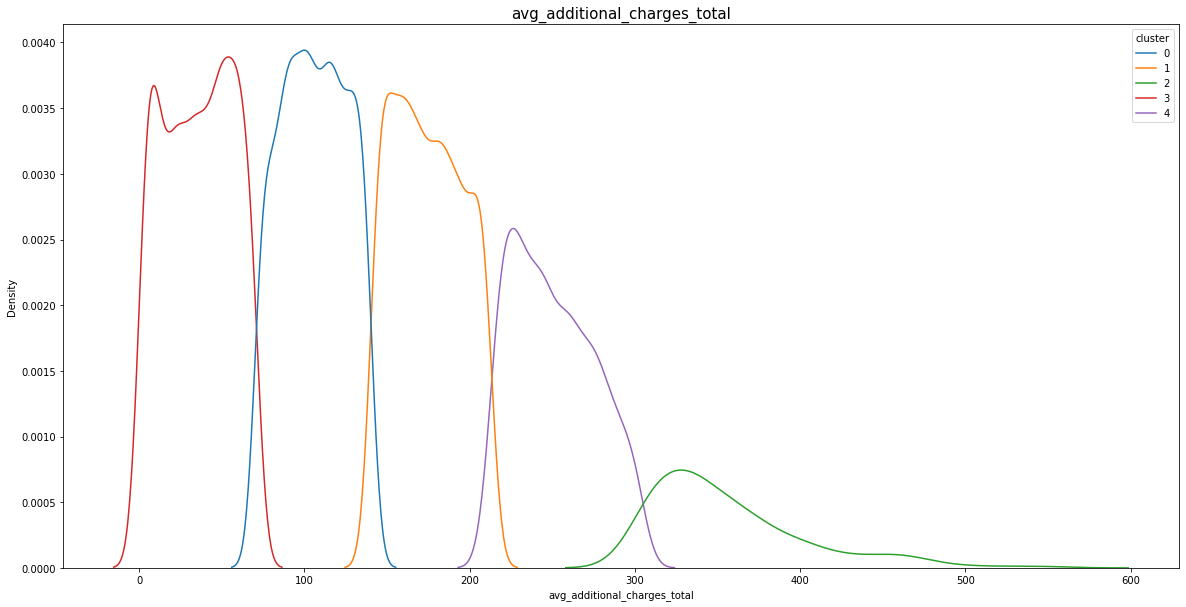

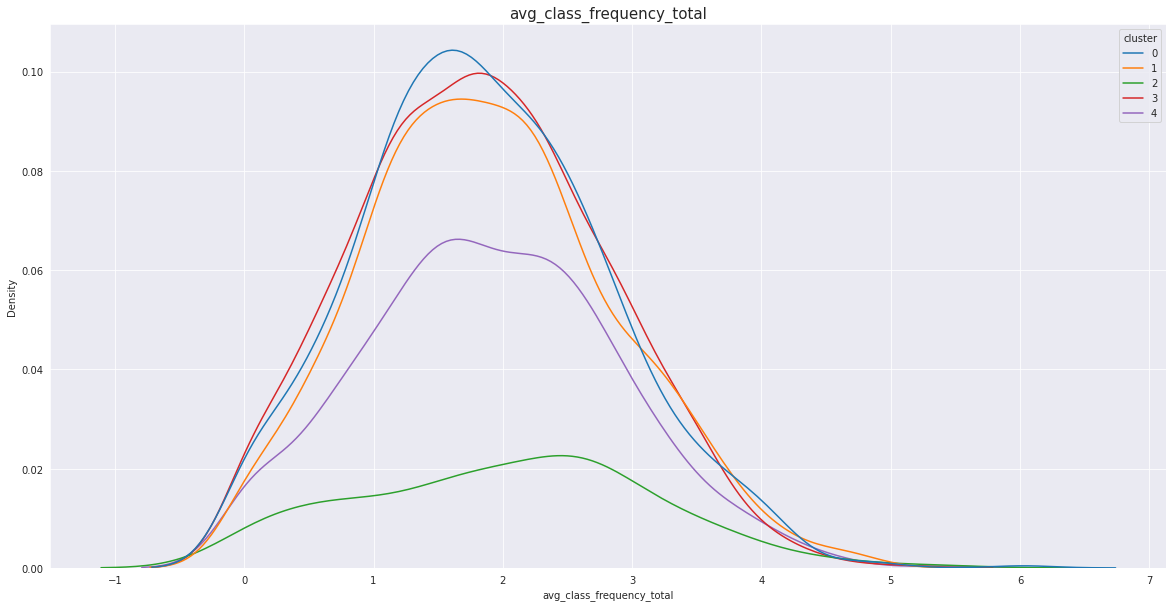

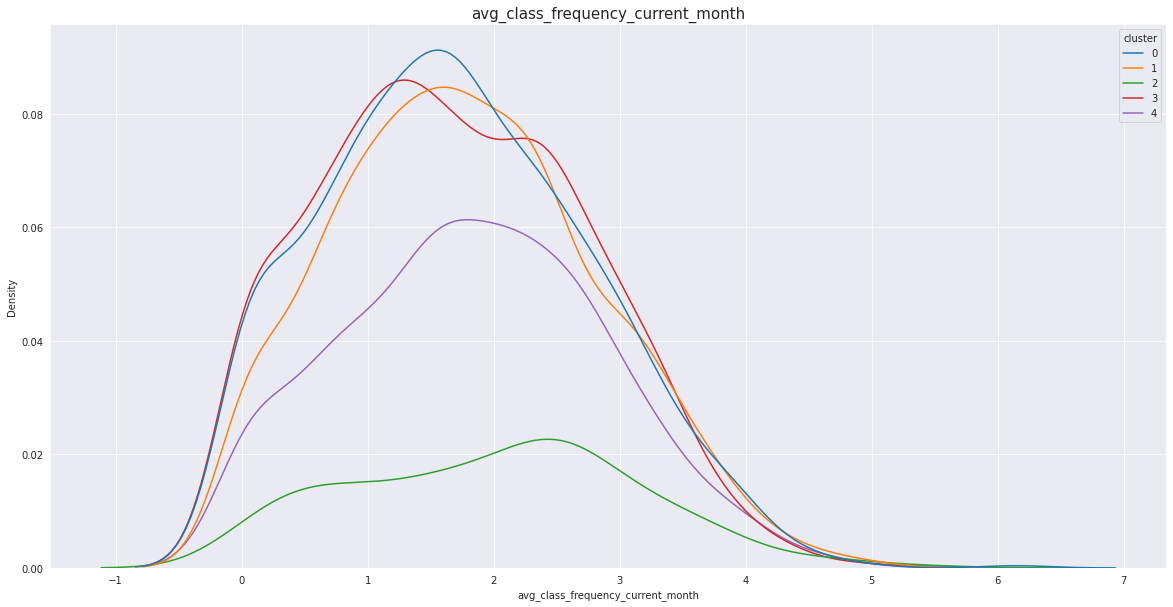

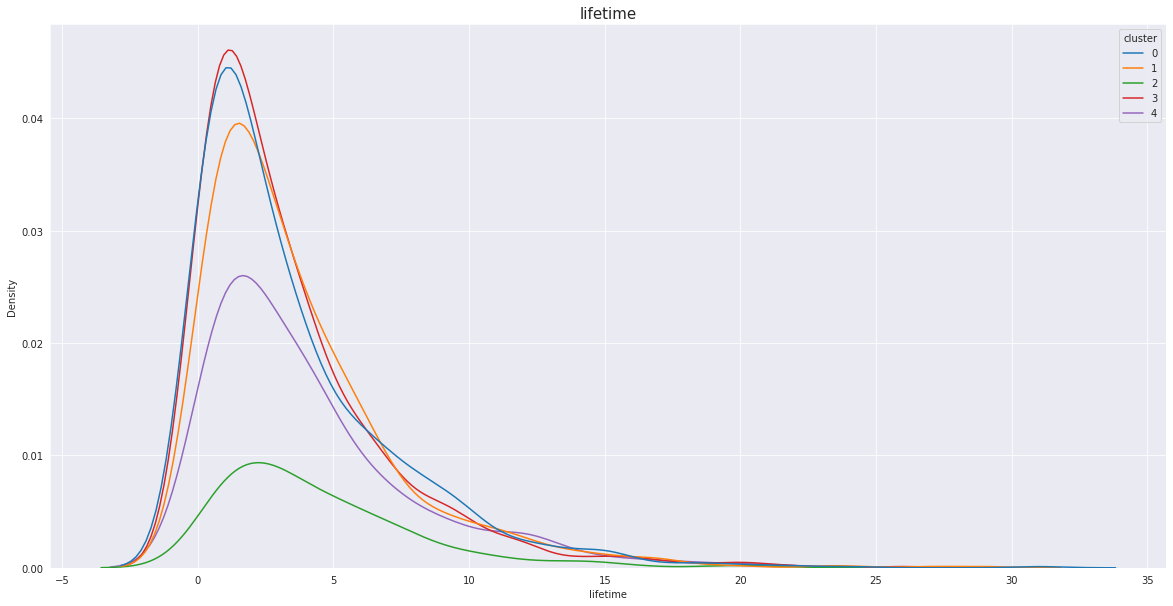

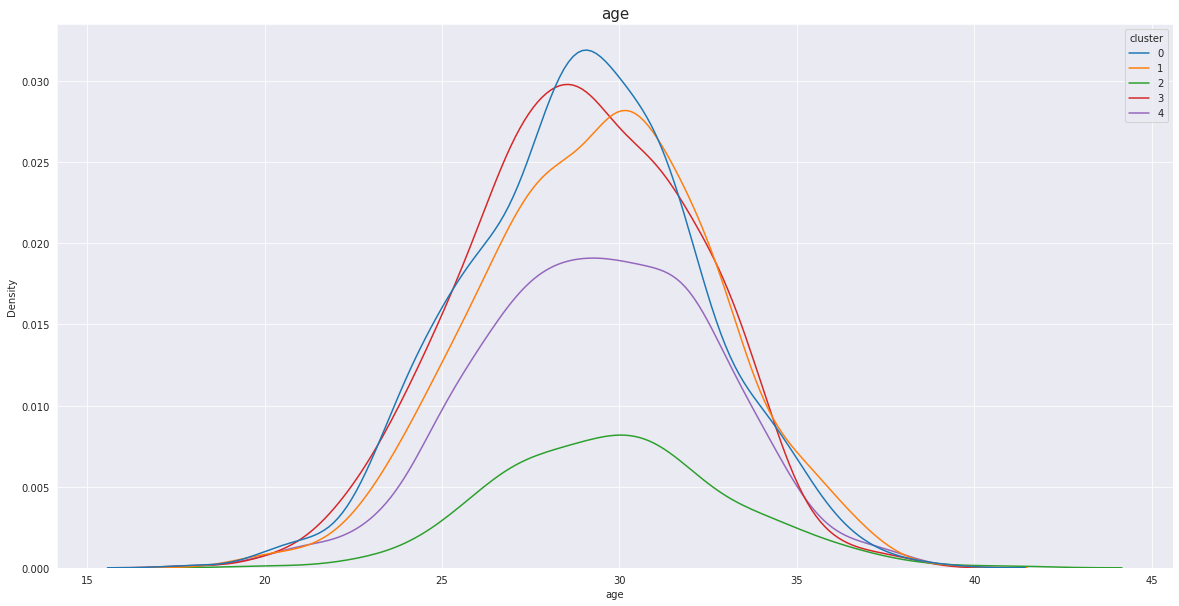

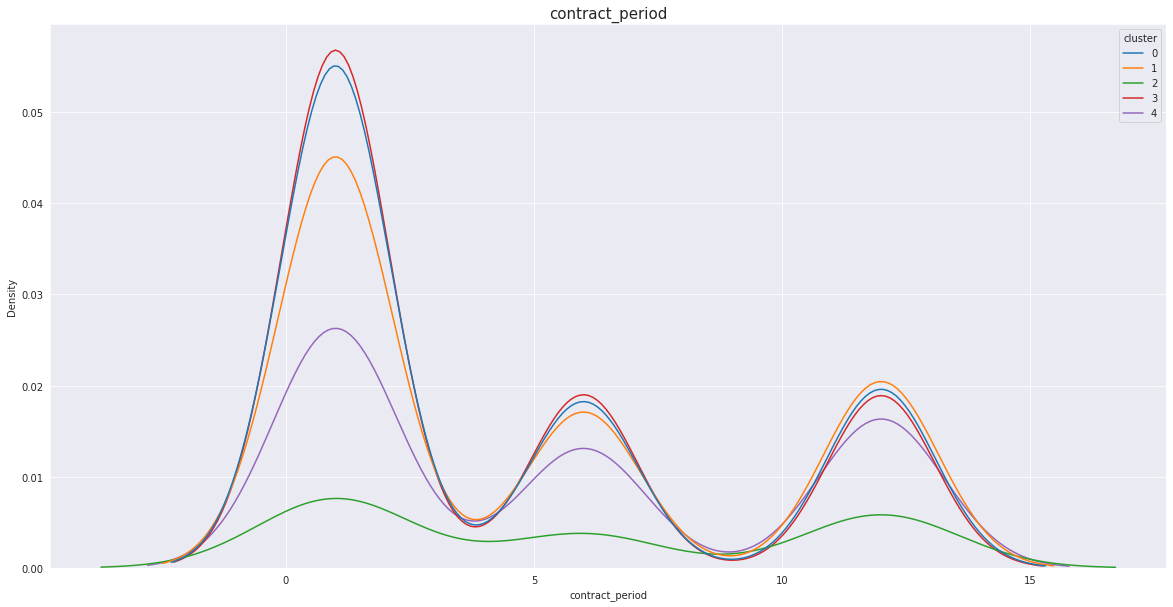

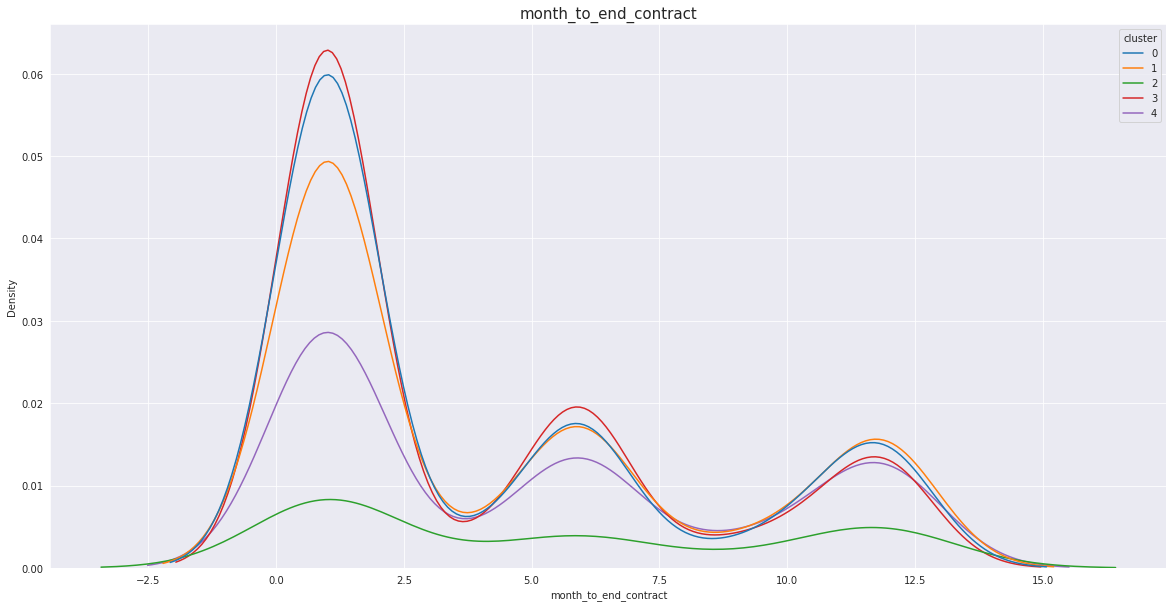

In [23]:
for column in ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']:
    plt.figure(figsize=(20, 10))
    plt.title(column, fontsize=15)   
    sns.kdeplot(data = gym, x = column, hue = 'cluster', palette='tab10')
    sns.set_style('darkgrid')
    plt.show()

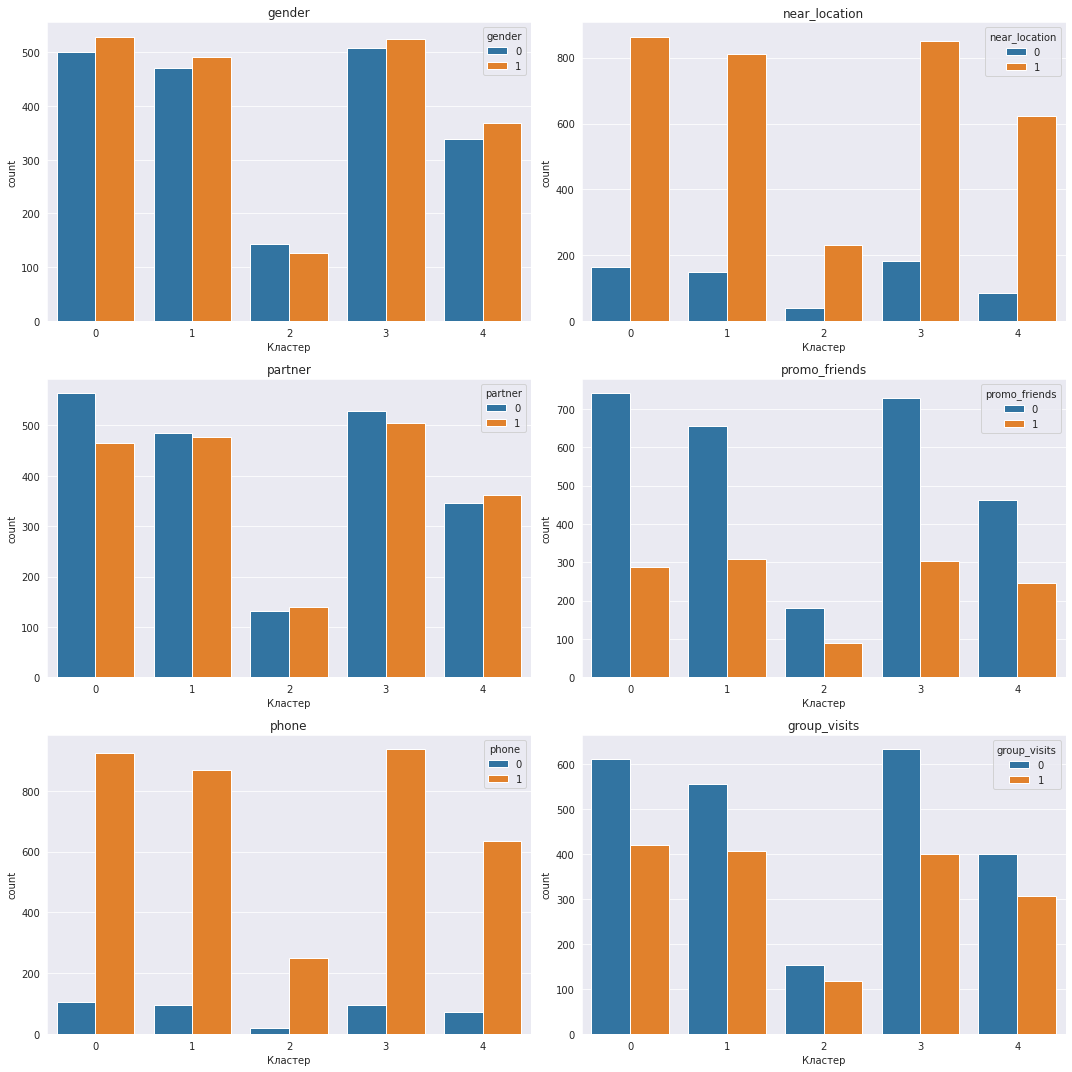

In [26]:
num_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

number_row = int(len(num_features)/2)

fig, ax = plt.subplots(nrows = number_row, ncols=2, figsize=(15, 15))
ax = ax.flatten()

for i in range(len(num_features)): 
    sns.countplot(data = gym, x='cluster', hue=num_features[i], ax=ax[i]) 
    ax[i].set_title(f'{num_features[i]}')
    ax[i].set_xlabel('Кластер')

fig.tight_layout()
fig.show()

### Для каждого полученного кластера посчитайем долю оттока

In [24]:
#Считаем долю оттока
gym.groupby('cluster').agg({'churn':'mean'}).sort_values(by='churn', ascending=False)

,churn
cluster,
3,0.349806
0,0.334305
1,0.226611
4,0.178470
2,0.044280


In [25]:
#Посмотрим на общее количество по кластерам
gym['cluster'].value_counts()

3    1032
0    1029
1     962
4     706
2     271
Name: cluster, dtype: int64

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**

- 3 и 0 кластеры имеют наибольшую долю оттока - 35% и 33%;
- 1 кластер находся в серединной доле оттока клиентов - 23%;
- 4 кластер имеет долю оттока в 18%.
- 2 же кластер имеет наименьшую долю оттока и имеет всего 4%;

**Надежный:**    
    
- 2 кластер является самым надежным, туда попало 706 клиентов, которы соответсвуют всем признакам: покупают долгосрочные абонементы, пользуются доп.услугами сервиса и т.д.
  
**Склонны к оттоку:**
- 3 и 0 кластеры являются самыми ненадежными, ведь они практически не посещают занятия, не пользуются доп. услугами сервиса и т.д.


## **Выводы и рекомендации**

### Общий вывод

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
    
**Предобработка данных:**
- Загрузили библиотеки и датафрейм, ознакомились с данными, дубликатов и пропусков обнаружено не было, исправлен формат столбцов;

**Исследовательский анализ данных:**
- Пол никак не влияет на отток;
- Возрастом клиентов, покупающих и использующих абонементы, является 27-30 лет;
- Если клиенты покупают краткосрочные абонементы, то появляется больший шанс оттока;
- Клиенты, посещающие групповые занятие и использующие "пригласи друга", уменьшают отток;
    
**Кластеризация клиентов:**
- **Кластеры 0 и 3:** самые ненадежные клиенты, их количество составляет 1029 и 1033, с вероятностью оттока в 35% и 33%;
- **Кластер 1:** серединные клиенты, составляющие 962 человека, с вероятностью оттока в 23%. Данные клиенты пользуются всеми услугами, однако у них средняя посещаемость;
- **Кластер 2:** самый надежный кластер, составляющий 271 человека с вероятностью оттока в 4%, что является лучшим результатом, среди всех кластером. Это объясняется тем, что в данную категорию попало наименьшее количество пользователей, а именно тех, кто пользуются всемии предоставляемыми возможностями сервиса;
- **Кластер 4:** также не менее надежный кластер, составляющий 706 человек, с вероятностью оттока в 18%.

### Рекомендации

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
    
1. Улучшить систему взаимодействия с пользователями, путем внедрения различных акций и технологий по развитию посещаемости и пользования доп.услугами сервиса
2. Мотивировать клиентов покупать годовые абонементы, включая в них ряд дополнительных услуг;
3. Увеличить проводимость групповых занятий, путем развития заинтересованности клиентов, возможно по возрастному или видовому критерию.